In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import scipy
from scipy import signal
from PIL import Image
from scipy.spatial.distance import hamming

In [3]:
def dct_2d(a):
    '''2D DCT'''
    return scipy.fftpack.dct( scipy.fftpack.dct( a, axis=0, norm='ortho' ), axis=1, norm='ortho' )

def image2hash(I, dct_size=32):
    I = I.resize((dct_size, dct_size))
    I = I.convert(mode='L')
    dct = dct_2d(I)
    square = np.array(I)[:8, :8]
    seq = square.flatten()
    phash = [0 if x < np.mean(seq) else 1 for x in seq]
    return np.array(phash)

def insert_message(image, message, L=0.1, padding=2):
    bs = image.shape[0] # image size
    k = 0
    for i in range(padding, bs - padding, 8):
        for j in range(padding, bs - padding, 8):
            Y = int(np.round(0.299*image[i][j][0] + 0.587*image[i][j][1] + 0.114*image[i][j][2]))
            if message[k] == 0:
                image[i][j][2] -= L * Y
            elif message[k] == 1:
                image[i][j][2] += L * Y
            k += 1
    return image

def extract_message(image, sigma=2, padding=2):
    bs = image.shape[0]
    message = np.zeros(64, dtype='uint8')
    k = 0
    for y in range(padding, bs - padding, 8):
        for x in range(padding, bs - padding, 8):
            B_hat = 0
            for s in range(1, sigma + 1):
                B_hat += int(image[y + s][x][2]) + int(image[y-s][x][2]) + int(image[y][x+s][2]) + int(image[y][x-s][2])
            B_hat /= 4*sigma
            if image[y][x][2] > B_hat:
                message[k] = 1
            elif image[y][x][2] < B_hat:
                message[k] = 0
            k += 1
    return message

def photoshop(image, amount=4):
    image_psotoshopped = np.copy(image)
    
    for i in range(amount):
        image_psotoshopped[32][32+i] = [255, 255, 255]
#         image_psotoshopped[33][32+i] = [255, 255, 255]
#         image_psotoshopped[34][32+i] = [255, 255, 255]
#         image_psotoshopped[35][32+i] = [255, 255, 255]


#         image_psotoshopped[33][32+i][0] = 255
#         image_psotoshopped[34][32+i][0] = 255
#         image_psotoshopped[35][32+i][0] = 255
    return image_psotoshopped

In [4]:
img = Image.open('bridge.jpg')
# img = Image.open('bridge-photoshoped.jpg')

blocksize = 64
pos_x, pos_y = 200, 350

block_img = img.crop((pos_x, pos_y, pos_x + blocksize, pos_y + blocksize)) # you can crop w/ np slices :)
block = np.array(block_img)

In [5]:
h1 = image2hash(block_img)
print('h1:')
print(h1.reshape(8,8))

h1:
[[0 0 0 0 0 1 1 1]
 [0 0 0 0 0 1 1 1]
 [0 0 0 0 0 1 1 1]
 [0 0 0 0 0 1 1 1]
 [0 0 0 0 0 1 1 1]
 [0 0 0 0 0 1 1 1]
 [0 0 0 0 0 1 1 1]
 [0 0 0 0 0 1 1 1]]


In [6]:
block_with_h1 = insert_message(block, h1, L=0.3)
extracted_hash = extract_message(block_with_h1)
print('\nextracted_hash:')
print(extracted_hash.reshape(8,8))
print('\nh1 == extracted_message:')
print((h1 == extracted_hash).reshape(8,8)*1)


extracted_hash:
[[0 0 0 0 0 1 1 1]
 [0 0 0 0 0 1 1 1]
 [0 0 0 0 0 1 1 1]
 [0 0 0 0 0 1 1 1]
 [0 0 0 0 0 1 1 1]
 [0 0 0 0 0 1 1 1]
 [0 0 0 0 0 1 1 1]
 [0 0 0 0 0 1 1 1]]

h1 == extracted_message:
[[1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]]


In [7]:
block_with_h1_photoshopped = photoshop(block_with_h1, amount=13)
h2 = extract_message(block_with_h1_photoshopped)
# h2 = extract_message(block_1_arr)
print('\nhash extracted from photoshopped image')
print(h2.reshape(8,8))
print('\nh1 == h2:')
print((h1 == h2).reshape(8,8)*1)


hash extracted from photoshopped image
[[0 0 0 0 0 1 1 1]
 [0 0 0 0 0 1 1 1]
 [0 0 0 0 0 1 1 1]
 [0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 1 1]
 [0 0 0 0 0 1 1 1]
 [0 0 0 0 0 1 1 1]
 [0 0 0 0 0 1 1 1]]

h1 == h2:
[[1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 0 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]]


In [8]:
print('\nhamming distance:', hamming(h1, h2))


hamming distance: 0.015625


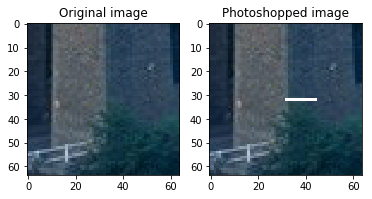

In [9]:
plt.figure(1)
plt.subplot(121)
plt.imshow(block)
plt.title('Original image')
plt.subplot(122)
plt.imshow(block_with_h1_photoshopped)
plt.title('Photoshopped image')